In [ ]:
import zipfile

with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
import os 

PATH = 'caltech101_classification'

classes = os.listdir(PATH)
classes

['schooner', 'Motorbikes', 'airplanes']

In [ ]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: schooner. Imágenes: 63
Categoría: Motorbikes. Imágenes: 798
Categoría: airplanes. Imágenes: 800


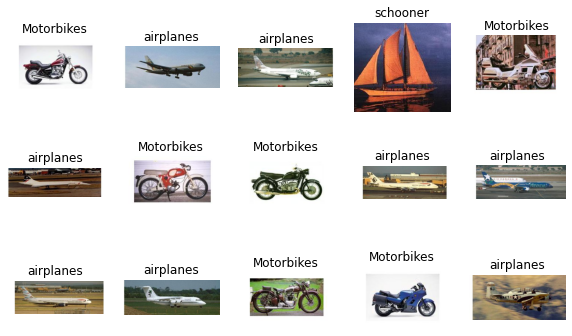

In [ ]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(1328, 333)

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [ ]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device), 
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(1328, 333)

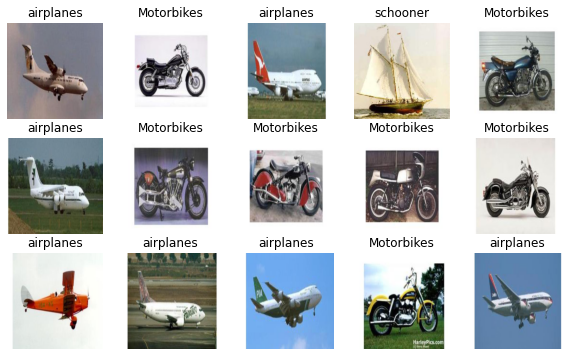

In [ ]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 224, 224])

In [ ]:
import torchvision

resnet = torchvision.models.resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=3, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, 3)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

In [ ]:
model = Model()
outputs = model(torch.randn(64, 3, 224, 224))
outputs.shape

torch.Size([64, 3])

In [ ]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [ ]:
model = Model()
fit(model, dataloader, epochs=10)

loss 1.04708 acc 0.40625:  10%|▉         | 2/21 [00:07<01:08,  3.61s/it]


RuntimeError: ignored

In [ ]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader, epochs=15)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

loss 1.13690 acc 0.35156:  10%|▉         | 2/21 [00:00<00:04,  4.48it/s]


RuntimeError: ignored